# Оцінка курсу долара за допомогою Нейронної Мережі LSTM

Виконав студент ІПЗм-11 Кича Андрій

LSTM - Long short-term memory. Використовується для аналізу часових рядів та рядів даних що взаємоповʼязані між собою.

Набір даних взято з ресурсу Yahoo Finance https://finance.yahoo.com/quote/USDUAH%3DX/history?p=USDUAH%3DX

In [393]:
import pandas as pd

## Переведення набору даних до формату pd

Створення дата фрейму pd важливе для спрощення маніпуляцій над набором даних

In [394]:
df = pd.read_csv('USDUAH.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-15,25.844999,26.069000,25.806601,25.806601,25.806601,0
1,2018-03-16,26.173000,26.173000,25.806601,25.806601,25.806601,0
2,2018-03-19,26.278000,26.278000,26.117500,25.931601,25.931601,0
3,2018-03-20,26.080999,26.080999,25.931601,26.117500,26.117500,0
4,2018-03-21,26.142000,26.142000,26.035500,26.049999,26.049999,0
...,...,...,...,...,...,...,...
1300,2023-03-09,36.638458,36.662598,36.638458,36.640369,36.640369,0
1301,2023-03-10,36.566570,36.630276,36.566570,36.662598,36.662598,0
1302,2023-03-13,36.353882,36.681011,36.353882,36.446461,36.446461,0
1303,2023-03-14,36.497410,36.497410,36.456516,36.681011,36.681011,0


## Фільтрація набору даних від непотрібної для тренування моделі інформації

In [395]:
df = df[['Date', 'Close']]

In [396]:
df

,Date,Close
0,2018-03-15,25.806601
1,2018-03-16,25.806601
2,2018-03-19,25.931601
3,2018-03-20,26.117500
4,2018-03-21,26.049999
...,...,...
1300,2023-03-09,36.640369
1301,2023-03-10,36.662598
1302,2023-03-13,36.446461
1303,2023-03-14,36.681011


## Переведення строкової репрезентації дати в обʼєкт

In [397]:
df['Date'] = df['Date'].apply(pd.to_datetime)

/var/folders/8d/rgvq80y13sj1394jhjl5vdxh0000gn/T/ipykernel_15026/1867011112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(pd.to_datetime)


In [398]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

## Візуалізація набору даних

In [399]:
import matplotlib.pyplot as plt

[]

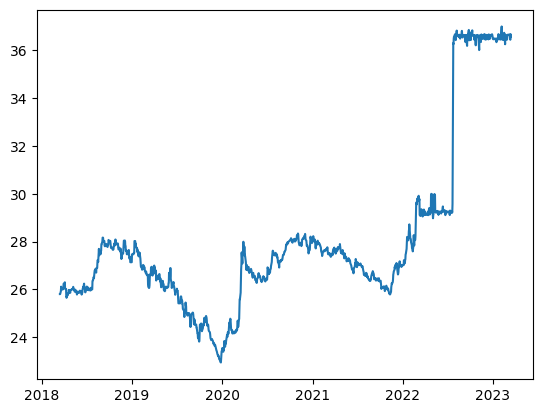

In [400]:
plt.plot(df['Date'].to_numpy(), df['Close'].to_numpy())
plt.plot()

## Використання дати як індексу у дата фреймі

In [401]:
df.index = df.pop('Date')

In [402]:
df

,Close
Date,
2018-03-15,25.806601
2018-03-16,25.806601
2018-03-19,25.931601
2018-03-20,26.117500
2018-03-21,26.049999
...,...
2023-03-09,36.640369
2023-03-10,36.662598
2023-03-13,36.446461


In [403]:
import numpy as np
import datetime

window_size = 3

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=window_size):
  first_date = pd.to_datetime(first_date_str)
  last_date  = pd.to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2019-03-15', 
                                '2023-03-15', 
                                n=window_size)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-03-15,26.083000,26.177999,26.497999,26.631001
1,2019-03-18,26.177999,26.497999,26.631001,26.615000
2,2019-03-19,26.497999,26.631001,26.615000,26.915001
3,2019-03-20,26.631001,26.615000,26.915001,26.924000
4,2019-03-21,26.615000,26.915001,26.924000,26.899000
...,...,...,...,...,...
1039,2023-03-09,36.658344,36.645271,36.640491,36.640369
1040,2023-03-10,36.645271,36.640491,36.640369,36.662598
1041,2023-03-13,36.640491,36.640369,36.662598,36.446461
1042,2023-03-14,36.640369,36.662598,36.446461,36.681011


In [404]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1044,), (1044, 3, 1), (1044,))

In [405]:
np.isnan(y).any(0)

False

## Фільтрація набору даних від пустих значень

In [406]:
windowed_df.shape

(1044, 5)

In [407]:
windowed_df.isnull().values.any()

False

In [408]:
windowed_df = windowed_df.dropna()
windowed_df.isnull().values.any()

False

In [409]:
windowed_df.shape

(1044, 5)

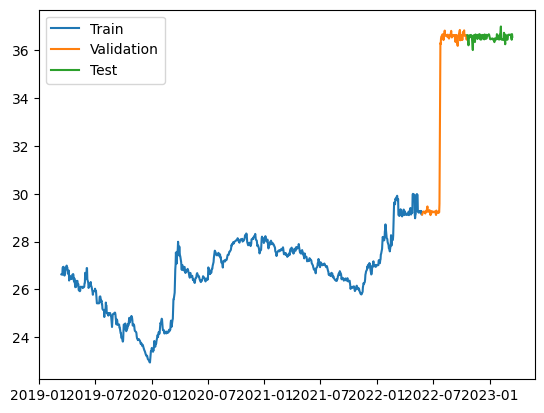

In [410]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.show()

## Композиція моделі

In [411]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# mean squared error
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['mean_absolute_error'])

## Тренування моделі

In [412]:
y_train

array([26.631   , 26.615   , 26.915   , 26.924   , 26.899   , 26.95    ,
       26.582   , 26.686   , 26.776   , 26.842   , 26.842   , 27.      ,
       26.899   , 26.928   , 26.813   , 26.66    , 26.791   , 26.375   ,
       26.444   , 26.57    , 26.566   , 26.448   , 26.519   , 26.468   ,
       26.445   , 26.607   , 26.645   , 26.609   , 26.399   , 26.331   ,
       26.464   , 26.093   , 26.144   , 26.149   , 26.117   , 26.358   ,
       26.358   , 26.227   , 26.221   , 26.221   , 25.977   , 25.933   ,
       25.928   , 25.952   , 26.116   , 26.102   , 26.107   , 26.114   ,
       26.114   , 26.059   , 26.073   , 26.098   , 26.115   , 26.262   ,
       26.271   , 26.698   , 26.462   , 26.54    , 26.895   , 26.895   ,
       26.424   , 26.285   , 26.064   , 26.101   , 26.101   , 26.21    ,
       26.243   , 26.311   , 26.151   , 26.143   , 26.097   , 25.89    ,
       25.779   , 25.906   , 25.931   , 25.931   , 25.928   , 26.032   ,
       25.934   , 25.95    , 25.95    , 25.421   , 

In [416]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500
27/27 [==============================] - 0s 6ms/step - loss: 496.4495 - mean_absolute_error: 22.2250 - val_loss: 886.1970 - val_mean_absolute_error: 29.5313
Epoch 2/500
27/27 [==============================] - 0s 4ms/step - loss: 492.7761 - mean_absolute_error: 22.1421 - val_loss: 881.8658 - val_mean_absolute_error: 29.4572
Epoch 3/500
27/27 [==============================] - 0s 4ms/step - loss: 489.0341 - mean_absolute_error: 22.0573 - val_loss: 877.4708 - val_mean_absolute_error: 29.3818
Epoch 4/500
27/27 [==============================] - 0s 4ms/step - loss: 485.2347 - mean_absolute_error: 21.9709 - val_loss: 873.0186 - val_mean_absolute_error: 29.3052
Epoch 5/500
27/27 [==============================] - 0s 4ms/step - loss: 481.3816 - mean_absolute_error: 21.8829 - val_loss: 868.4565 - val_mean_absolute_error: 29.2265
Epoch 6/500
27/27 [==============================] - 0s 4ms/step - loss: 477.4785 - mean_absolute_error: 21.7933 - val_loss: 863.7792 - val_mean_absolute_e

27/27 [==============================] - 0s 4ms/step - loss: 263.5348 - mean_absolute_error: 16.1483 - val_loss: 586.0403 - val_mean_absolute_error: 23.8739
Epoch 50/500
27/27 [==============================] - 0s 4ms/step - loss: 258.2796 - mean_absolute_error: 15.9850 - val_loss: 578.6373 - val_mean_absolute_error: 23.7176
Epoch 51/500
27/27 [==============================] - 0s 4ms/step - loss: 253.0608 - mean_absolute_error: 15.8205 - val_loss: 571.1866 - val_mean_absolute_error: 23.5593
Epoch 52/500
27/27 [==============================] - 0s 4ms/step - loss: 247.8714 - mean_absolute_error: 15.6556 - val_loss: 563.7802 - val_mean_absolute_error: 23.4008
Epoch 53/500
27/27 [==============================] - 0s 4ms/step - loss: 242.7286 - mean_absolute_error: 15.4903 - val_loss: 556.3782 - val_mean_absolute_error: 23.2414
Epoch 54/500
27/27 [==============================] - 0s 4ms/step - loss: 237.6333 - mean_absolute_error: 15.3248 - val_loss: 549.0126 - val_mean_absolute_error: 2

27/27 [==============================] - 0s 4ms/step - loss: 71.0012 - mean_absolute_error: 8.2617 - val_loss: 275.8557 - val_mean_absolute_error: 16.0957
Epoch 98/500
27/27 [==============================] - 0s 4ms/step - loss: 68.5009 - mean_absolute_error: 8.1095 - val_loss: 270.9155 - val_mean_absolute_error: 15.9416
Epoch 99/500
27/27 [==============================] - 0s 4ms/step - loss: 66.0617 - mean_absolute_error: 7.9583 - val_loss: 266.0327 - val_mean_absolute_error: 15.7880
Epoch 100/500
27/27 [==============================] - 0s 4ms/step - loss: 63.6887 - mean_absolute_error: 7.8075 - val_loss: 261.2112 - val_mean_absolute_error: 15.6348
Epoch 101/500
27/27 [==============================] - 0s 4ms/step - loss: 61.3807 - mean_absolute_error: 7.6586 - val_loss: 256.4934 - val_mean_absolute_error: 15.4835
Epoch 102/500
27/27 [==============================] - 0s 4ms/step - loss: 59.1316 - mean_absolute_error: 7.5110 - val_loss: 251.8520 - val_mean_absolute_error: 15.3332
Ep

27/27 [==============================] - 0s 4ms/step - loss: 8.2898 - mean_absolute_error: 2.5231 - val_loss: 117.8797 - val_mean_absolute_error: 10.0862
Epoch 146/500
27/27 [==============================] - 0s 4ms/step - loss: 7.8855 - mean_absolute_error: 2.4577 - val_loss: 116.1101 - val_mean_absolute_error: 9.9987
Epoch 147/500
27/27 [==============================] - 0s 4ms/step - loss: 7.5050 - mean_absolute_error: 2.3957 - val_loss: 114.4117 - val_mean_absolute_error: 9.9141
Epoch 148/500
27/27 [==============================] - 0s 4ms/step - loss: 7.1493 - mean_absolute_error: 2.3375 - val_loss: 112.7474 - val_mean_absolute_error: 9.8304
Epoch 149/500
27/27 [==============================] - 0s 4ms/step - loss: 6.8145 - mean_absolute_error: 2.2814 - val_loss: 111.1209 - val_mean_absolute_error: 9.7479
Epoch 150/500
27/27 [==============================] - 0s 4ms/step - loss: 6.4985 - mean_absolute_error: 2.2272 - val_loss: 109.5756 - val_mean_absolute_error: 9.6689
Epoch 151/5

27/27 [==============================] - 0s 4ms/step - loss: 2.5555 - mean_absolute_error: 1.2613 - val_loss: 76.8964 - val_mean_absolute_error: 7.8194
Epoch 195/500
27/27 [==============================] - 0s 4ms/step - loss: 2.5497 - mean_absolute_error: 1.2587 - val_loss: 76.6837 - val_mean_absolute_error: 7.8061
Epoch 196/500
27/27 [==============================] - 0s 4ms/step - loss: 2.5443 - mean_absolute_error: 1.2559 - val_loss: 76.4422 - val_mean_absolute_error: 7.7909
Epoch 197/500
27/27 [==============================] - 0s 4ms/step - loss: 2.5399 - mean_absolute_error: 1.2533 - val_loss: 76.2116 - val_mean_absolute_error: 7.7766
Epoch 198/500
27/27 [==============================] - 0s 4ms/step - loss: 2.5364 - mean_absolute_error: 1.2517 - val_loss: 76.0691 - val_mean_absolute_error: 7.7678
Epoch 199/500
27/27 [==============================] - 0s 4ms/step - loss: 2.5341 - mean_absolute_error: 1.2506 - val_loss: 75.9693 - val_mean_absolute_error: 7.7619
Epoch 200/500
27/2

27/27 [==============================] - 0s 4ms/step - loss: 2.4813 - mean_absolute_error: 1.2254 - val_loss: 72.8526 - val_mean_absolute_error: 7.5778
Epoch 244/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4808 - mean_absolute_error: 1.2257 - val_loss: 72.8751 - val_mean_absolute_error: 7.5804
Epoch 245/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4800 - mean_absolute_error: 1.2248 - val_loss: 72.6705 - val_mean_absolute_error: 7.5662
Epoch 246/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4791 - mean_absolute_error: 1.2234 - val_loss: 72.5339 - val_mean_absolute_error: 7.5569
Epoch 247/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4778 - mean_absolute_error: 1.2232 - val_loss: 72.5021 - val_mean_absolute_error: 7.5555
Epoch 248/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4771 - mean_absolute_error: 1.2228 - val_loss: 72.4186 - val_mean_absolute_error: 7.5502
Epoch 249/500
27/2

27/27 [==============================] - 0s 4ms/step - loss: 2.4299 - mean_absolute_error: 1.2103 - val_loss: 70.3932 - val_mean_absolute_error: 7.4451
Epoch 293/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4280 - mean_absolute_error: 1.2108 - val_loss: 70.6267 - val_mean_absolute_error: 7.4628
Epoch 294/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4264 - mean_absolute_error: 1.2111 - val_loss: 70.5111 - val_mean_absolute_error: 7.4556
Epoch 295/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4266 - mean_absolute_error: 1.2119 - val_loss: 70.5797 - val_mean_absolute_error: 7.4615
Epoch 296/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4231 - mean_absolute_error: 1.2097 - val_loss: 70.1893 - val_mean_absolute_error: 7.4347
Epoch 297/500
27/27 [==============================] - 0s 4ms/step - loss: 2.4225 - mean_absolute_error: 1.2095 - val_loss: 70.3359 - val_mean_absolute_error: 7.4462
Epoch 298/500
27/2

27/27 [==============================] - 0s 4ms/step - loss: 2.3102 - mean_absolute_error: 1.1825 - val_loss: 67.5415 - val_mean_absolute_error: 7.2976
Epoch 342/500
27/27 [==============================] - 0s 4ms/step - loss: 2.3077 - mean_absolute_error: 1.1822 - val_loss: 67.5551 - val_mean_absolute_error: 7.2997
Epoch 343/500
27/27 [==============================] - 0s 4ms/step - loss: 2.3057 - mean_absolute_error: 1.1821 - val_loss: 67.4585 - val_mean_absolute_error: 7.2943
Epoch 344/500
27/27 [==============================] - 0s 4ms/step - loss: 2.3019 - mean_absolute_error: 1.1802 - val_loss: 67.1246 - val_mean_absolute_error: 7.2725
Epoch 345/500
27/27 [==============================] - 0s 4ms/step - loss: 2.3002 - mean_absolute_error: 1.1780 - val_loss: 66.8553 - val_mean_absolute_error: 7.2551
Epoch 346/500
27/27 [==============================] - 0s 4ms/step - loss: 2.2972 - mean_absolute_error: 1.1778 - val_loss: 66.9871 - val_mean_absolute_error: 7.2654
Epoch 347/500
27/2

27/27 [==============================] - 0s 4ms/step - loss: 2.1612 - mean_absolute_error: 1.1441 - val_loss: 63.7253 - val_mean_absolute_error: 7.0866
Epoch 391/500
27/27 [==============================] - 0s 4ms/step - loss: 2.1558 - mean_absolute_error: 1.1424 - val_loss: 63.4772 - val_mean_absolute_error: 7.0703
Epoch 392/500
27/27 [==============================] - 0s 4ms/step - loss: 2.1515 - mean_absolute_error: 1.1391 - val_loss: 63.0386 - val_mean_absolute_error: 7.0404
Epoch 393/500
27/27 [==============================] - 0s 4ms/step - loss: 2.1464 - mean_absolute_error: 1.1379 - val_loss: 63.0663 - val_mean_absolute_error: 7.0437
Epoch 394/500
27/27 [==============================] - 0s 4ms/step - loss: 2.1402 - mean_absolute_error: 1.1362 - val_loss: 62.8522 - val_mean_absolute_error: 7.0298
Epoch 395/500
27/27 [==============================] - 0s 4ms/step - loss: 2.1345 - mean_absolute_error: 1.1342 - val_loss: 62.6908 - val_mean_absolute_error: 7.0197
Epoch 396/500
27/2

27/27 [==============================] - 0s 4ms/step - loss: 1.6430 - mean_absolute_error: 0.9989 - val_loss: 53.5490 - val_mean_absolute_error: 6.4704
Epoch 440/500
27/27 [==============================] - 0s 4ms/step - loss: 1.6295 - mean_absolute_error: 0.9953 - val_loss: 53.3833 - val_mean_absolute_error: 6.4608
Epoch 441/500
27/27 [==============================] - 0s 4ms/step - loss: 1.6158 - mean_absolute_error: 0.9912 - val_loss: 53.1262 - val_mean_absolute_error: 6.4439
Epoch 442/500
27/27 [==============================] - 0s 4ms/step - loss: 1.6007 - mean_absolute_error: 0.9863 - val_loss: 52.8412 - val_mean_absolute_error: 6.4253
Epoch 443/500
27/27 [==============================] - 0s 4ms/step - loss: 1.5859 - mean_absolute_error: 0.9824 - val_loss: 52.6003 - val_mean_absolute_error: 6.4099
Epoch 444/500
27/27 [==============================] - 0s 4ms/step - loss: 1.5689 - mean_absolute_error: 0.9767 - val_loss: 52.3921 - val_mean_absolute_error: 6.3970
Epoch 445/500
27/2

27/27 [==============================] - 0s 4ms/step - loss: 0.5752 - mean_absolute_error: 0.5928 - val_loss: 34.5111 - val_mean_absolute_error: 5.0800
Epoch 489/500
27/27 [==============================] - 0s 4ms/step - loss: 0.5568 - mean_absolute_error: 0.5838 - val_loss: 34.1378 - val_mean_absolute_error: 5.0515
Epoch 490/500
27/27 [==============================] - 0s 4ms/step - loss: 0.5388 - mean_absolute_error: 0.5729 - val_loss: 33.6103 - val_mean_absolute_error: 5.0051
Epoch 491/500
27/27 [==============================] - 0s 4ms/step - loss: 0.5204 - mean_absolute_error: 0.5648 - val_loss: 33.3371 - val_mean_absolute_error: 4.9876
Epoch 492/500
27/27 [==============================] - 0s 4ms/step - loss: 0.5017 - mean_absolute_error: 0.5534 - val_loss: 32.7796 - val_mean_absolute_error: 4.9346
Epoch 493/500
27/27 [==============================] - 0s 4ms/step - loss: 0.4847 - mean_absolute_error: 0.5438 - val_loss: 32.4909 - val_mean_absolute_error: 4.9150
Epoch 494/500
27/2

## Оцінка якості передбачень моделі

27/27 [==============================] - 0s 2ms/step


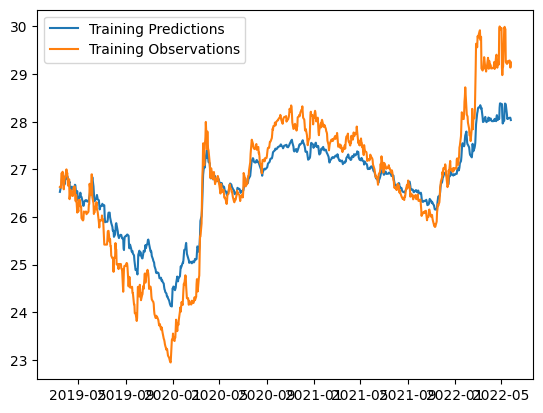

In [418]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

plt.show()